<a href="https://colab.research.google.com/github/stanislavfort/slice-dice-optimize/blob/main/cutting_planes_in_JAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Code for the paper *What does a deep neural network confidently perceive? The effective dimension of high certainty class manifolds and their low confidence boundaries*

This Colab demonstrates the core experiment of the paper *What does a deep neural network confidently perceive? The effective dimension of high certainty class manifolds and their low confidence boundaries*. It trains a model from scratch for a few epochs, conducts input space partitioning experiments using random hyperplanes, and calculates the effective dimension $d^*_{50\%}$  for the class manifolds for each of the CIFAR-10 classes.


The notebook will train a ResNet20v1 on CIFAR-10 for a few epochs and perform our core cutting plane experiment for each single class manifold using a sweep of cutting plane dimensions $d$, each repeated 5 times. You should be able to run this from scratch on a free Google Colab GPU in less than 5 minutes. The resulting figure will look like this:

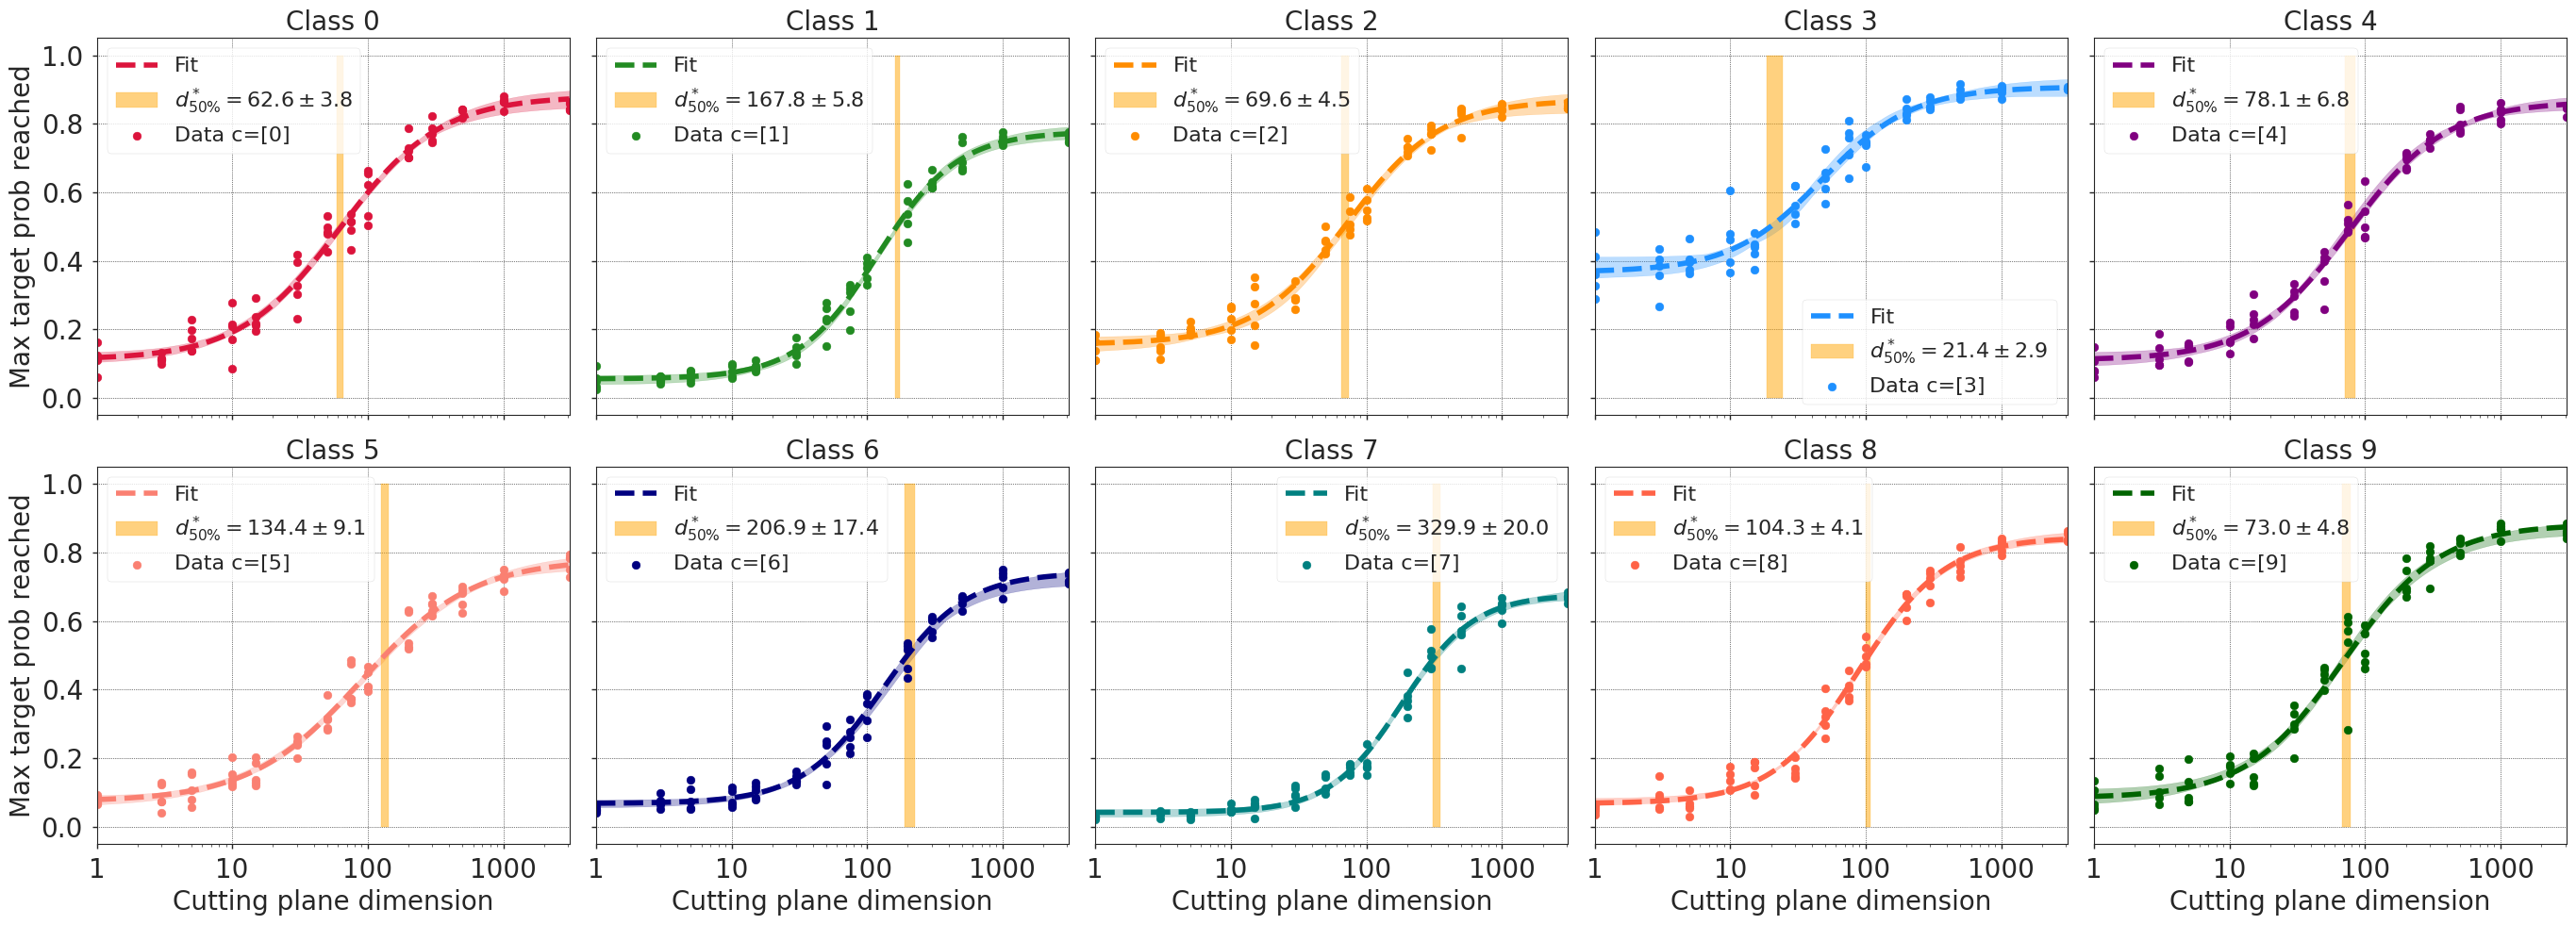


# Loading libraries

In [2]:
#@title

# getting the versions for which the code works
!pip install jax==0.2.9 https://storage.googleapis.com/jax-releases/cuda112/jaxlib-0.1.61+cuda112-cp37-none-manylinux2010_x86_64.whl
!pip install jaxlib==0.1.61 https://storage.googleapis.com/jax-releases/cuda112/jaxlib-0.1.61+cuda112-cp37-none-manylinux2010_x86_64.whl
!pip install flax==v0.3.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.0/158.0 MB 9.1 MB/s eta 0:00:00
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.1.59+cuda111
    Uninstalling jaxlib-0.1.59+cuda111:
      Successfully uninstalled jaxlib-0.1.59+cuda111
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached https://storage.googleapis.com/jax-releases/cuda112/jaxlib-0.1.61+cuda112-cp37-none-manylinux2010_x86_64.whl (158.0 MB)
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Libraries

In [3]:
#@title
import jax

# jax.config.enable_omnistaging()

import flax

import numpy as onp #original numpy
import jax.numpy as jnp #jax numpy

import tensorflow_datasets as tfds

from jax.experimental import optimizers
from flax import nn

import math
import time

import jax.ops as ops
import jax.random as random

import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/flax/nn/__init__.py:35: DeprecationWarning: The `flax.nn` module is Deprecated, use `flax.linen` instead. Learn more and find an upgrade guide at https://github.com/google/flax/blob/master/flax/linen/README.md
  warnings.warn("The `flax.nn` module is Deprecated, use `flax.linen` instead. Learn more and find an upgrade guide at https://github.com/google/flax/blob/master/flax/linen/README.md", DeprecationWarning)


# Plotting style

In [4]:
#@title
import matplotlib as mpl
import seaborn as sns
sns.set_style("ticks")

mpl.style.use('seaborn-notebook')
mpl.rcParams.update({'font.size': 14, 'lines.linewidth': 2, 'figure.figsize': (6, 6/1.61)})
mpl.rcParams['grid.color'] = 'k'
mpl.rcParams['grid.linestyle'] = ':'
mpl.rcParams['grid.linewidth'] = 0.5
mpl.rcParams['lines.markersize'] = 6
mpl.rcParams['lines.marker'] = None
mpl.rcParams['axes.grid'] = True
COLORS = plt.rcParams["axes.prop_cycle"].by_key()["color"]

DEFAULT_FONTSIZE = 13
mpl.rcParams.update({'font.size': DEFAULT_FONTSIZE, 'lines.linewidth': 2, 
                    'legend.fontsize': DEFAULT_FONTSIZE, 'axes.labelsize': DEFAULT_FONTSIZE, 
                    'xtick.labelsize': DEFAULT_FONTSIZE, 'ytick.labelsize': DEFAULT_FONTSIZE, 'figure.figsize': (7, 7.0/1.4)})

markers_list = ["o","x","D","*","^"]


plt.rcParams['svg.fonttype'] = 'none'

# Example architectures

## Simple CNN architecture

In [5]:
class CNN(flax.nn.Module):
  def apply(self, x, classes = 10, channels = [32,64,64,128], train=False):

    for features in channels:
      x = flax.nn.Conv(x, features=features, kernel_size=(3, 3))
      x = flax.nn.relu(x)
      x = flax.nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))

    #getting it flat
    x = x.reshape((x.shape[0], -1))

    # final layer
    x = flax.nn.Dense(x, features=classes)
    x = flax.nn.log_softmax(x)
    return x

## ResNets

In [6]:
class KerasResNets(flax.nn.Module): #inspired by the Keras examples and rewritten to JAX
  
  def apply(self, x, train=True, depth = (3*6+2), num_classes=10, use_batch_norm=True):

    def resnet_layer(inputs,
                     num_filters=16,
                     kernel_size=3,
                     strides=1,
                     activation="relu",
                     conv_first=True,
                     train=True,
                     ):
      
      if use_batch_norm:
        batch_norm = nn.BatchNorm.partial(use_running_average=not train,momentum=0.9, epsilon=1e-5)
      
      if activation == "relu":
        f = flax.nn.relu
      elif activation is None:
        f = lambda q: q

      a = inputs
      if conv_first:
        a = flax.nn.Conv(a, features=num_filters,strides=(strides,strides),padding="SAME",kernel_size=(3, 3))
        if use_batch_norm:
          a = batch_norm(a)
        a = f(a)
      else:
        if use_batch_norm:
          a = batch_norm(a)
        a = f(a)
        a = flax.nn.Conv(a, features=num_filters,strides=(strides,strides),padding="SAME",kernel_size=(3, 3))
      
      return a

    if (depth - 2) % 6 != 0:
          raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
      
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = x
    x = resnet_layer(inputs=inputs, train=train)

    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                            num_filters=num_filters,
                            strides=strides, train=train)
            
            y = resnet_layer(inputs=y,
                            num_filters=num_filters,
                            activation=None, train=train)
            
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                num_filters=num_filters,
                                kernel_size=1,
                                strides=strides,
                                activation=None, train=train)
                
            x = x+y
            x = flax.nn.relu(x)
        num_filters *= 2

    x = flax.nn.avg_pool(x, window_shape=(8, 8), strides=(8, 8))

    x = x.reshape((x.shape[0], -1))
    x = flax.nn.Dense(x, features=num_classes)
    x = flax.nn.log_softmax(x)

    return x



# Choosing the architecture

In [7]:
classes = 10 #has to match the number of classes of the chosen dataset

#choose on of the two examples, the default is ResNet
model_choice = "ResNet"
# model_choice = "SimpleCNN"

if model_choice == "ResNet":
  model_to_use = KerasResNets.partial(
    num_classes = classes,
    use_batch_norm = True,
  )
  model_name = "ResNetBN"

elif model_choice == "SimpleCNN":
  model_to_use = CNN.partial(
    classes = classes,
  )
  model_name = "SimpleCNN"

else:
  print("Architecture "+str(model_choice)+" not found!")
  assert False

# Utils

In [8]:
#@title
from flax.training import lr_schedule

def make_lr_fun(base_lr, steps_per_epoch):  
  return lr_schedule.create_stepped_learning_rate_schedule(base_lr, steps_per_epoch,[[80, 0.01], [120, 0.001]])

default_LR = 0.1
learning_rate_fn = make_lr_fun(default_LR, int(float(50000)/float(128))) # the standard ResNet training schedule (>91% test after 200 epochs)


@jax.vmap
def cross_entropy_loss(logits, label):
  return -logits[label]

def compute_metrics(logits, labels):
  loss = jnp.mean(cross_entropy_loss(logits, labels))
  accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
  return {'loss': loss, 'accuracy': accuracy}

@jax.jit
def train_step(step, optimizer, batch, state):

  def loss_fn(model):

    with flax.nn.stateful(state) as new_state: #to update the state
      logits = model(batch['image'])

    loss = jnp.mean(cross_entropy_loss(
        logits, batch['label']))
    
    params = model.params

    #for L2 penalty on the loss
    weight_penalty_params = jax.tree_leaves(params)
    weight_decay = 1e-4
    weight_l2 = sum([jnp.sum(x ** 2)
                      for x in weight_penalty_params
                      if x.ndim > 2])
    weight_penalty = weight_decay * 0.5 * weight_l2

    return loss + weight_penalty, new_state

  grad_fn = jax.value_and_grad(loss_fn, has_aux=True)

  (_, new_state), grad = grad_fn(optimizer.target)

  new_optimizer = optimizer.apply_gradient(grad, learning_rate=learning_rate_fn(step))

  return new_optimizer, new_state

@jax.jit
def eval(model, eval_ds, state):
  with flax.nn.stateful(state, mutable=False):
    logits = model(eval_ds['image'], train=False)
  return compute_metrics(logits, eval_ds['label'])


def normal_loss(params, batch, train=True):
  logits = jax.nn.log_softmax(model_to_use.call(params, batch['image'], train = train))
  loss = jnp.mean(cross_entropy_loss(logits, batch['label']))
  return loss

def normal_accuracy(params,batch, train=True):
  logits = jax.nn.log_softmax(model_to_use.call(params, batch['image'], train = train))
  return jnp.mean(jnp.argmax(logits, -1) == batch['label'])


# Dataset

## Choosing dataset

In [9]:
dataset_choice = "CIFAR10"
# dataset_choice = "CIFAR100"

#additional settings for fun experiments

#for real numbers between 0 and 1 uses only a fraction of the train set
#for None uses the whole train set
train_fraction = None 

#label randomization for memorization experiments
consistently_randomize_ys = False #True makes train and test labels random


## Loading dataset

In [10]:
#@title
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.datasets import cifar10,cifar100

subtract_pixel_mean = True

if dataset_choice == "CIFAR10":
  classes = 10
  (x_train, y_train), (x_test, y_test) = cifar10.load_data()
elif dataset_choice == "CIFAR100":
  classes = 100
  (x_train, y_train), (x_test, y_test) = cifar100.load_data()

y_train = y_train.reshape([-1])
y_test = y_test.reshape([-1])


if train_fraction is None:
  pass
else:
  n_to_keep = int(onp.ceil(float(len(x_train))*train_fraction))
  ids_to_keep = onp.random.choice(range(len(x_train)),(n_to_keep),replace = False)
  x_train = x_train[ids_to_keep]
  y_train = y_train[ids_to_keep]
  print("train_fraction",train_fraction)
  print("x_train",x_train.shape)
  print("y_train",y_train.shape)


#consistent randomization of labels
if consistently_randomize_ys:
  print("LABEL RANDOMIZATION IS ON!!")
  y_train = onp.random.choice(range(classes),y_train.shape,replace=True)
  y_test = onp.random.choice(range(classes),y_test.shape,replace=True)

# Input image dimensions.
input_shape = x_train.shape[1:]

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# If subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = onp.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

orig_x_train = onp.array(x_train)
orig_y_train = onp.array(y_train)

In [11]:
#@title
N_train = len(x_train)
N_test = len(x_test)

train_ds = {
  'image': orig_x_train.astype(jnp.float32),
  'label': orig_y_train.astype(jnp.int32)
}

test_ds = {
  'image': x_test.astype(jnp.float32),
  'label': y_test.astype(jnp.int32)
}

# Model training loop

## Training setup

In [12]:
points_to_collect = 1 #how many times to train
epochs = 5 #how many epochs for to train

batch_size = 128 

## The training loop

In [13]:
ts = []

# collecting train params and states
params_collected_by_iteration = [[] for _ in range(points_to_collect)]
states_collected_by_iteration = [[] for _ in range(points_to_collect)]

#which iterations to save the params at
def it_to_save_fn(it):
  return (it % 100 == 0) or (it in [0,1,2,3,4,5,6,7,8,9,10]) or ((10<it<100) and (it % 10 == 0))

for point_id in range(points_to_collect):

  with flax.nn.stateful() as init_state_raw:
    _, initial_params = model_to_use.init_by_shape(jax.random.PRNGKey(point_id+9381577432), [((128, 32, 32, 3), jnp.float32)])
    model = flax.nn.Model(model_to_use, initial_params)
    init_state = init_state_raw

  state = init_state # for the batch norm params

  optimizer = flax.optim.Momentum(learning_rate=0.1, beta=0.9).create(model) #the LR doesn't matter, it changes on every update based on the train fn

  print("Number of params = "+str(onp.sum([onp.prod(x.shape) for x in jax.tree_flatten(initial_params)[0]])))
    
  params_collected_by_iteration[point_id].append((None,initial_params))
  states_collected_by_iteration[point_id].append((None,state))

  total_it = -1
  t1 = time.time()

  while True:

    #getting a random batch
    batch_ids = onp.random.choice(range(len(train_ds["image"])),(batch_size),replace = False)
    batch = {
      "image": train_ds["image"][batch_ids],
      "label": train_ds["label"][batch_ids],
    }

    total_it = total_it + 1

    if total_it / (len(x_train)/float(batch_size)) > epochs:
      break

    #getting the update step
    optimizer,state = train_step(total_it, optimizer, batch, state)

    #getting the params out
    params_now = optimizer.target.params

    if it_to_save_fn(total_it): #collecting parameters as training progresses
      params_collected_by_iteration[point_id].append((total_it,params_now))
      states_collected_by_iteration[point_id].append((total_it,state))

    #batch loss and acc
    metrics = eval(optimizer.target, batch, state)
    loss_out = metrics["loss"]
    accuracy_out = metrics["accuracy"]

    e_float = total_it / (len(x_train)/float(batch_size))

    #looking at test set once every epoch
    if (total_it % int(len(x_train)/float(batch_size))) in [0]:  
      #test verification

      #doing the BN averaing on the test
      test_loss_out_testBN = normal_loss(params_now,test_ds)
      test_accuracy_out_testBN = normal_accuracy(params_now,test_ds)

      t2 = time.time()
      if total_it > 0:
        ts.append(t2-t1)
        t_rem_str = str(int(onp.mean(ts)*points_to_collect*epochs - onp.sum(ts)))
      else:
        t_rem_str = "TBD" 
      t1 = time.time()


      print("e="+str(e_float)+
            " it="+str(total_it)+
            " train loss="+str(loss_out)+
            " train acc="+str(accuracy_out)+
            " test loss="+str(test_loss_out_testBN)+
            " test acc="+str(test_accuracy_out_testBN)+
            " t_rem="+str(t_rem_str)
            )
      


Number of params = 293738
e=0.0 it=0 train loss=2.2940078 train acc=0.171875 test loss=2.333832 test acc=0.134 t_rem=TBD
e=0.9984 it=390 train loss=1.1339157 train acc=0.5703125 test loss=1.0766958 test acc=0.6072 t_rem=28
e=1.9968 it=780 train loss=0.8727927 train acc=0.734375 test loss=0.8154734 test acc=0.71910006 t_rem=21
e=2.9952 it=1170 train loss=0.58769953 train acc=0.7734375 test loss=0.69177145 test acc=0.76690006 t_rem=14
e=3.9936 it=1560 train loss=0.48068973 train acc=0.8515625 test loss=0.63807964 test acc=0.78330004 t_rem=7
e=4.992 it=1950 train loss=0.27739197 train acc=0.90625 test loss=0.62492067 test acc=0.7892 t_rem=0


# Checking the learning curves

In [14]:
test_preds = [ [] for _ in range(len(params_collected_by_iteration))]
its = [ [] for _ in range(len(params_collected_by_iteration))]

times = []

t1 = time.time()

skip = 1

for i_run in range(len(params_collected_by_iteration)):

  params_collected_now = params_collected_by_iteration[i_run]

  for i_step in list(range(len(params_collected_now)))[::skip]:

    (it,params_now) = params_collected_now[i_step]

    if i_step % 10 == 0:
      print(i_run,i_step,"/",len(params_collected_now))

    test_preds_now = model_to_use.call(params_now, test_ds["image"])

    test_preds[i_run].append(test_preds_now)
    its[i_run].append(it)

    t2 = time.time()
    times.append(t2-t1)
    t1 = time.time()


0 0 / 39
0 10 / 39
0 20 / 39
0 30 / 39


In [15]:
test_accs = onp.zeros((len(test_preds),len(test_preds[0])))

for point_id in range(len(test_preds)):
  accs_now = onp.mean(onp.argmax(test_preds[point_id],axis=-1) == y_test.reshape([1,-1]),axis=-1)
  test_accs[point_id] = accs_now

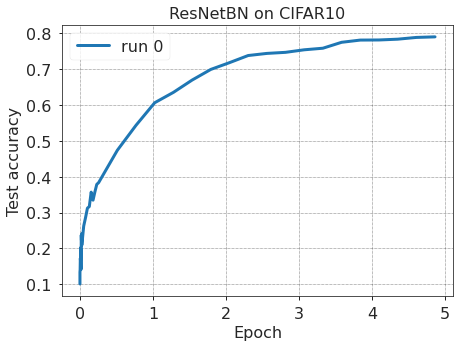

In [16]:
plt.figure(figsize = (7,5))
plt.title(model_name+" on "+dataset_choice,fontsize = 16)

for point_id in range(len(test_accs)):

  epochs_nice = []

  for i in range(len(its[point_id])):
    it_now = its[point_id][i]
    if it_now is None:
      epochs_nice.append(0)
    else:
      epochs_nice.append(it_now*128.0/50000.0)

  plt.plot(epochs_nice,test_accs[point_id],label = "run "+str(point_id),linewidth = 3)

plt.grid(True)

plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

plt.xlabel("Epoch",fontsize = 16)
plt.ylabel("Test accuracy",fontsize = 16)

plt.legend(fontsize = 16)

plt.show()

# One-hot utils

In [17]:
#@title

@jax.vmap
def onehot_cross_entropy_loss(logits, onehot):
  return -jnp.sum(logits*onehot)

def onehot_compute_metrics(logits, onehot):
  loss = jnp.mean(onehot_cross_entropy_loss(logits, onehot))
  accuracy = jnp.mean(jnp.argmax(logits, -1) == jnp.argmax(onehot, -1))
  return {'loss': loss, 'accuracy': accuracy}

def onehot_normal_loss(params, batch, ensemble_set_of_params = None):

  if ensemble_set_of_params is None: #the normal single params
    logits = jax.nn.log_softmax(model_to_use.call(params, batch['image']))
  else: #ensemble
    logits_list = []
    for params_now in ensemble_set_of_params:
      logits_list.append(jax.nn.log_softmax(model_to_use.call(params_now, batch['image'])))
    logits = jnp.mean(jnp.stack(logits_list,axis=0),axis=0)

  loss = jnp.mean(onehot_cross_entropy_loss(logits, batch['onehot']))

  return loss

def onehot_normal_accuracy(params,batch,ensemble_set_of_params = None):

  if ensemble_set_of_params is None: #the normal single params
    logits = jax.nn.log_softmax(model_to_use.call(params, batch['image']))
  else: #ensemble
    logits_list = []
    for params_now in ensemble_set_of_params:
      logits_list.append(jax.nn.log_softmax(model_to_use.call(params_now, batch['image'])))
    logits = jnp.mean(jnp.stack(logits_list,axis=0),axis=0)

  return jnp.mean(jnp.argmax(logits, -1) == jnp.argmax(batch['onehot'],axis=-1))


# Cutting plane fns

In [18]:
#within plane params into an image
@jax.jit
def theta_to_image(theta,M,X0):
  return (jnp.matmul(theta,M)).reshape([-1,32,32,3]) + X0.reshape([-1,32,32,3])

#within plane params into a loss via an image fed into a NN
@jax.jit
def theta_to_loss(theta,M,X0,onehot_target,params, ensemble_set_of_params = None):
  return onehot_normal_loss(params,{"image": theta_to_image(theta,M,X0), "onehot": onehot_target},ensemble_set_of_params)

#the gradient of the within plane params based on the loss
def give_me_theta_grad(theta,M,X0,onehot_target,params, ensemble_set_of_params = None):
  theta_loss_prefilled = lambda theta_now: theta_to_loss(theta_now,M,X0,onehot_target, params, ensemble_set_of_params)
  return jax.grad(theta_loss_prefilled)(theta)


# Make projection matrix

In [19]:
def make_bases(d,D,k_nonzero = None,enforce_no_overlap_if_possible = True):

  M_random = onp.random.normal(loc=0.0,scale=1.0,size=(d,D))

  if k_nonzero is None: #no conditions on axis alignment
    M_now = M_random
  else:
    M_now = onp.zeros((d,D))

    if ((k_nonzero*d <= D) and (enforce_no_overlap_if_possible == True)):
      ids_flat = onp.random.choice(range(D),(k_nonzero*d),replace=False)
      ids_shaped = ids_flat.reshape([d,k_nonzero])
    elif ((k_nonzero*d <= D) and (enforce_no_overlap_if_possible == False)):
      ids_flat = onp.random.choice(range(D),(k_nonzero*d),replace=True)
      ids_shaped = ids_flat.reshape([d,k_nonzero])
    else:
      ids_flat = onp.random.choice(range(D),(k_nonzero*d),replace=True)
      ids_shaped = ids_flat.reshape([d,k_nonzero])

    for i in range(d):
      M_now[i,ids_shaped[i]] = M_random[i,ids_shaped[i]]
  
  #normalization to unit length of each basis vector
  M_now = M_now / onp.linalg.norm(M_now,axis=-1,keepdims=True)  

  return M_now

# Encapsulation of plane optimization

In [20]:
from jax import ops
from jax import lax

def fast_optimize_on_plane(
    LR = 5e-2, #the learning rate on the cutting plane
    plane_steps = 100, #the max number of gradient descent steps
    classes=10, #the number of classes
    low_loss_stopping_threshold = 1e-2, #stops optimization when loss is low enough 
    std_loss_stopping_threshold = 1e-3, #stops optimization when loss doesn't change enough
    ):
  
  def optimize_fn(
      M, #bases of the projection plane
      X0, #the point defining the projection plane
      Y, #the target labels for optimization
      params, #networks params for single network
      ensemble_set_of_params = None #list of network params if ensemble is used
      ):
    
    #class targets
    onehot_target = jnp.zeros((classes))
    onehot_target = ops.index_update(onehot_target, jnp.array(Y), 1.0/float(len(Y)))
    onehot_target = onehot_target.reshape([1,-1])
  
    #defining Adam params
    beta_1=0.9
    beta_2=0.999
    epsilon=1e-07

    d = M.shape[0] #plane dimension

    #adam vectors
    vector_mass = jnp.zeros((1, d))
    vector_velocity = jnp.zeros((1, d))

    #storing results
    losses_buffer = jnp.zeros((plane_steps,))
    probs_buffer = jnp.zeros((plane_steps, classes))
    thetas_buffer = jnp.zeros((plane_steps,))

    #starting off
    theta = jnp.zeros((1, d))  

    target_loss = jnp.log(len(class_targets))

    def cond_fn(state):
      i, theta, mass, velocity, losses, probs, thetas = state
      cond = ((i < plane_steps) & 
              (jnp.abs(losses[i - 1] - target_loss) > low_loss_stopping_threshold))
      look_back = 5
      look_back_buff = lax.dynamic_slice(losses, (i - look_back,), (look_back,))
      cond = cond & (jnp.abs(jnp.std(look_back_buff)) > std_loss_stopping_threshold)
      return (i <= 5) | cond

    def inner_fn(state):
      i, theta, mass, velocity, losses, probs, thetas = state

      g = give_me_theta_grad(theta, M, X0, onehot_target, params, ensemble_set_of_params)
      loss = theta_to_loss(theta, M, X0, onehot_target, params, ensemble_set_of_params)

      if ensemble_set_of_params is None: #the usual single model
        preds = jax.nn.softmax(
            model_to_use.call(params, theta_to_image(theta, M, X0)),
            axis=-1
            )
      else: #the ensembling mode
        preds_all = jnp.zeros((1,classes))
        for params_now in ensemble_set_of_params:
          preds_now = jax.nn.softmax(
            model_to_use.call(params_now, theta_to_image(theta, M, X0)),
            axis=-1
            )
          preds_all += preds_now
        preds = preds_all / float(len(ensemble_set_of_params))

      
      losses = ops.index_update(losses, i, loss)
      probs = ops.index_update(probs, i, preds[0])
      thetas = ops.index_update(thetas, i, jnp.linalg.norm(theta))

      mass = beta_1 * mass + (1.0 - beta_1) * g
      velocity = beta_2 * velocity + (1.0 - beta_2) * (g**2.0)

      hat_mass = mass / (1.0-beta_1)
      hat_velocity = velocity / (1.0-beta_2)

      #the update to params in the plane
      theta = theta - LR / (jnp.sqrt(hat_velocity) + epsilon) * hat_mass

      return i + 1, theta, mass, velocity, losses, probs, thetas

    state = (0, theta, vector_mass, vector_velocity, 
             losses_buffer, probs_buffer, thetas_buffer)
    state = lax.while_loop(cond_fn, inner_fn, state)

    i, _, _, _, losses_buffer, probs_buffer, thetas_buffer = state

    return state[0], losses_buffer, probs_buffer, thetas_buffer 
  return optimize_fn

# Getting a train image

In [21]:
#getting a train image to start from that is NOT any of the target classes
def get_train_image(exclude_classes = [], classes = 10):

  if set(exclude_classes) != set(list(range(classes))):
    # print("selective")
    allowed = onp.ones((len(train_ds["label"]))).astype(onp.bool)
    for c in exclude_classes:
      class_bools = train_ds["label"] == c
      allowed = onp.logical_and(allowed,onp.logical_not(class_bools))
    id_selected = onp.random.choice(onp.array(range(len(train_ds["label"])))[allowed],(1))[0]
    
  else:
    # print("all allowed")
    allowed = onp.ones((len(train_ds["label"]))).astype(onp.bool)
    id_selected = onp.random.choice(onp.array(range(len(train_ds["label"])))[allowed],(1))[0]
  return train_ds["image"][id_selected]

# Plotter

In [22]:
#@title
from scipy.optimize import curve_fit

#empirical fit
def func(x, a, b, c, d):
    return a + b/(1.0+onp.exp(-(onp.log(x)-onp.log(c))/d))

def func2(x, a, b, c, d):
    return -onp.log(a + b/(1.0+onp.exp(-(onp.log(x)-onp.log(c))/d)))

def make_a_plot(storing_results,class_targets):

  #extracting data
  ds_collected = [qs[0] for qs in storing_results]
  ps_collected = [onp.max(onp.sum(qs[4][:,class_targets],axis=-1)) for qs in storing_results]
  losses_collected = [onp.min(qs[5][:]) for qs in storing_results]


  plt.figure(figsize = (2*6.5,5.5))

  plt.suptitle(model_name+" on "+dataset_choice+", target classes="+str(class_targets),fontsize = 20)

  plt.subplot(1,2,1)
  plt.title("Probabilities",fontsize = 18)

  #doing the probability fit
  try:
    p0 = [0.0,1.0,30.0,2.0]
    popt, pcov = curve_fit(func, ds_collected, ps_collected, p0 = p0)
    fit_done = True
  except:
    fit_done = False

  plt.semilogx()
  plt.scatter(ds_collected,ps_collected,marker = "o",color = "crimson",s = 60,label = "data c="+str(class_targets))

  ds_unique = list(sorted(list(set(ds_collected))))

  if fit_done == True:
    #adding the fit
    xs_fit = onp.linspace(onp.min(ds_unique),onp.max(ds_unique),10000)
    ys_fit = func(xs_fit,*popt)

    label = "Fit"

    plt.plot(xs_fit,ys_fit,linestyle = "--",color = "crimson",linewidth = 4,label = label)

    M_fns = 50
    all_fit_params = onp.random.multivariate_normal(mean = popt,cov = pcov, size=(M_fns))
    ys_fit_all = []
    for params in all_fit_params:
      ys_fit = func(xs_fit,*params)
      ys_fit_all.append(ys_fit)
    ys_fit_all = onp.array(ys_fit_all)

    plt.fill_between(xs_fit,onp.min(ys_fit_all,axis=0),onp.max(ys_fit_all,axis=0),color = "crimson",alpha = 0.3)

    #getting the distribution of crossing 50%
    min_ids = onp.argmin(onp.abs(onp.array(ys_fit_all) - 0.5),axis=-1)
    d_50_min = onp.min(xs_fit[min_ids])
    d_50_max = onp.max(xs_fit[min_ids])

    mean_str = "{:.1f}".format((d_50_min+d_50_max)/2.0)
    error_str = "{:.1f}".format((d_50_max-d_50_min)/2.0)
    label = "$d^*_{50\%}="+mean_str+"\pm"+error_str+"$"
    plt.fill_between([d_50_min,d_50_max],[0.0,0.0],[1.0,1.0],color = "orange",alpha = 0.5,label = label)

  plt.xlim([0,3072])



  plt.xlabel("Cutting plane dimension",fontsize = 16)
  plt.ylabel("Max probability reached",fontsize = 16)

  plt.xticks(fontsize = 16)
  plt.yticks(fontsize = 16)
  plt.legend(fontsize = 16)


  plt.subplot(1,2,2)
  plt.title("Losses",fontsize = 18)

  #doing the probability fit
  try:
    p0 = [0.0,1.0,30.0,2.0]
    popt, pcov = curve_fit(func2, ds_collected, losses_collected, p0 = p0)
    fit_done = True
  except:
    fit_done = False

  plt.semilogx()
  plt.scatter(ds_collected,losses_collected,marker = "o",color = "navy",s = 60,label = "data c="+str(class_targets))


  ds_unique = list(sorted(list(set(ds_collected))))


  if fit_done == True:
    #adding the fit
    xs_fit = onp.linspace(onp.min(ds_unique),onp.max(ds_unique),10000)
    ys_fit = func2(xs_fit,*popt)

    label = "Fit"

    plt.plot(xs_fit,ys_fit,linestyle = "--",color = "navy",linewidth = 4,label = label)

    M_fns = 50
    all_fit_params = onp.random.multivariate_normal(mean = popt,cov = pcov, size=(M_fns))
    ys_fit_all = []
    for params in all_fit_params:
      ys_fit = func2(xs_fit,*params)
      ys_fit_all.append(ys_fit)
    ys_fit_all = onp.array(ys_fit_all)

    plt.fill_between(xs_fit,onp.min(ys_fit_all,axis=0),onp.max(ys_fit_all,axis=0),color = "navy",alpha = 0.3)

    #getting the distribution of crossing 0.1 loss
    min_ids = onp.argmin(onp.abs(onp.array(ys_fit_all) - 0.3),axis=-1)
    d_50_min = onp.min(xs_fit[min_ids])
    d_50_max = onp.max(xs_fit[min_ids])

  plt.xlim([0,3072])


  plt.xlabel("Cutting plane dimension",fontsize = 16)
  plt.ylabel("Min loss reached",fontsize = 16)

  plt.xticks(fontsize = 16)
  plt.yticks(fontsize = 16)
  plt.legend(fontsize = 16)

  # plt.tight_layout()

  plt.show()

# Cutting plane experiment

## Experiment settings

In [23]:
D_input = 32*32*3 #the input space dimension, 32*32*3 for CIFAR-10

#choosing the latest trained params from the first run
params_to_use = params_collected_by_iteration[0][-1][1]

#for ensembling

#turns off ensembling
ensemble_set_of_params = None
ensemble_model_ids = []

#for ensembling, uncomment the following
# ensemble_model_ids = [0,1,2,3,4,5,6,7,8,9] #models chosen into the ensemble
# ensemble_set_of_params = [params_collected_by_iteration[i][-1][1] for i in ensemble_model_ids]
# print("Ensembling "+str(ensemble_model_ids))

LR = 5e-2 #plane LR
plane_steps = 300 #max number of steps

#type of hyperplanes 
plane_type = "random" #no axis alignemnt
# plane_type = 1 #axis aligned vectors, choose between 1 and D_input

if plane_type == "random":
  plane_nonzero_per_vector = None
else:
  plane_nonzero_per_vector = int(plane_type)

print("Plane type "+str(plane_type)+" => non-zero="+str(plane_nonzero_per_vector))


Plane type random => non-zero=None


## Sweep definition

In [24]:
reps = 5 #number of repetitions of each experiment

#the cutting plane dimensions to explore
ds_to_explore = [1,3,5,10,15,30,50,75,100,200,300,500,1000,3072] 

# which classes to optimize towards
class_targets_to_explore = [
  [0],[1],[2],[3],[4],[5],[6],[7],[8],[9],
  #[0,1,2,3], #an example of an in-between-class region
]

## Cutting plane experimental loop (<5 min on a free Google Colab GPU)

Starting cs=[0]
onehot_target [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


d=1 rep=0/5 p=[0.09024578]->0.12460524 loss=2.0826046 stop step=40 dt=3.897268295288086
d=1 rep=1/5 p=[0.0952718]->0.095325746 loss=2.3504553 stop step=6 dt=0.10646200180053711
d=1 rep=2/5 p=[0.12531188]->0.14332235 loss=1.9426591 stop step=15 dt=0.10699343681335449
d=1 rep=3/5 p=[0.1049168]->0.1336188 loss=2.0127645 stop step=57 dt=0.23787593841552734
d=1 rep=4/5 p=[0.13363738]->0.16737838 loss=1.7874984 stop step=51 dt=0.22213435173034668
d=3 rep=0/5 p=[0.15890495]->0.18030137 loss=1.7131256 stop step=28 dt=0.15216636657714844
d=3 rep=1/5 p=[0.13552237]->0.18369377 loss=1.6944852 stop step=27 dt=0.1423354148864746
d=3 rep=2/5 p=[0.15767148]->0.18077245 loss=1.7105161 stop step=21 dt=0.12981748580932617
d=3 rep=3/5 p=[0.13892332]->0.14718501 loss=1.9160649 stop step=20 dt=0.11920332908630371
d=3 rep=4/5 p=[0.13362703]->0.1411601 loss=1.9578607 stop step=19 dt=0.12260866165161133
d=5 rep=0/5 p=[0.17335032]->0.22583014 loss=1.4879721 stop step=39 dt=0.17593598365783691
d=5 rep=1/5 p=[0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:122: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


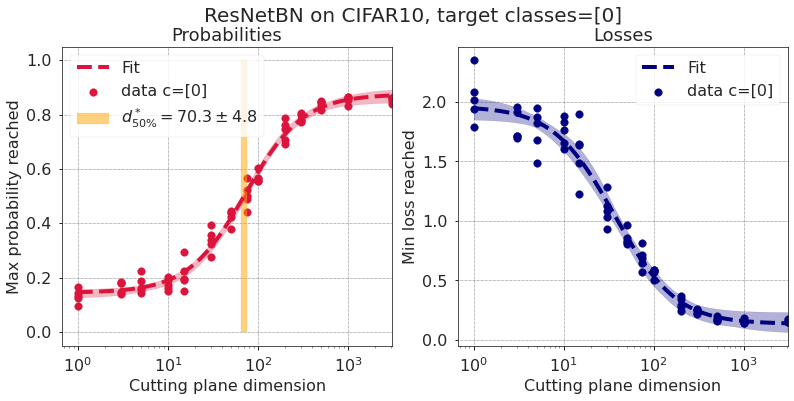

Time remaining approximately 193 seconds.
Starting cs=[1]
onehot_target [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


d=1 rep=0/5 p=[0.08661616]->0.08851106 loss=2.4246278 stop step=16 dt=0.12195825576782227
d=1 rep=1/5 p=[0.04413596]->0.04415742 loss=3.1199944 stop step=6 dt=0.0856328010559082
d=1 rep=2/5 p=[0.08717486]->0.087536484 loss=2.4356995 stop step=10 dt=0.09863924980163574
d=1 rep=3/5 p=[0.06120227]->0.061229624 loss=2.7931242 stop step=6 dt=0.08631515502929688
d=1 rep=4/5 p=[0.07642459]->0.07676459 loss=2.5670118 stop step=6 dt=0.08003544807434082
d=3 rep=0/5 p=[0.02331141]->0.034308843 loss=3.3723521 stop step=25 dt=0.13747453689575195
d=3 rep=1/5 p=[0.04496174]->0.053025577 loss=2.9369807 stop step=20 dt=0.13224244117736816
d=3 rep=2/5 p=[0.06397388]->0.08060896 loss=2.5181456 stop step=35 dt=0.16631078720092773
d=3 rep=3/5 p=[0.05289824]->0.053924326 loss=2.9201736 stop step=8 dt=0.08904647827148438
d=3 rep=4/5 p=[0.08597825]->0.12159711 loss=2.107042 stop step=20 dt=0.1317613124847412
d=5 rep=0/5 p=[0.04049308]->0.045764685 loss=3.0842426 stop step=19 dt=0.1202700138092041
d=5 rep=1/5 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:122: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


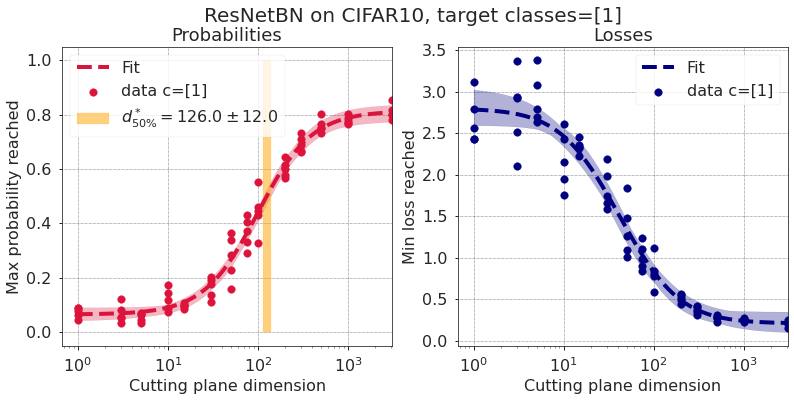

Time remaining approximately 149 seconds.
Starting cs=[2]
onehot_target [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]
d=1 rep=0/5 p=[0.15806434]->0.16687436 loss=1.7905141 stop step=25 dt=0.15018248558044434


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


d=1 rep=1/5 p=[0.10448486]->0.108192 loss=2.2238479 stop step=12 dt=0.10148882865905762
d=1 rep=2/5 p=[0.10260885]->0.14377435 loss=1.9395101 stop step=43 dt=0.19841599464416504
d=1 rep=3/5 p=[0.11578163]->0.11643678 loss=2.1504068 stop step=7 dt=0.09615612030029297
d=1 rep=4/5 p=[0.08810606]->0.090677984 loss=2.4004407 stop step=12 dt=0.1052103042602539
d=3 rep=0/5 p=[0.21868464]->0.2532864 loss=1.3732344 stop step=19 dt=0.1242372989654541
d=3 rep=1/5 p=[0.07360371]->0.10243032 loss=2.2785726 stop step=39 dt=0.18527436256408691
d=3 rep=2/5 p=[0.14775775]->0.14990261 loss=1.8977695 stop step=8 dt=0.08853268623352051
d=3 rep=3/5 p=[0.07635991]->0.20806739 loss=1.5698932 stop step=21 dt=0.12427949905395508
d=3 rep=4/5 p=[0.187915]->0.25958246 loss=1.3486809 stop step=50 dt=0.21913957595825195
d=5 rep=0/5 p=[0.17220905]->0.27469587 loss=1.2920908 stop step=76 dt=0.3023192882537842
d=5 rep=1/5 p=[0.09243]->0.14927141 loss=1.901989 stop step=39 dt=0.1897144317626953
d=5 rep=2/5 p=[0.1736247

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:122: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


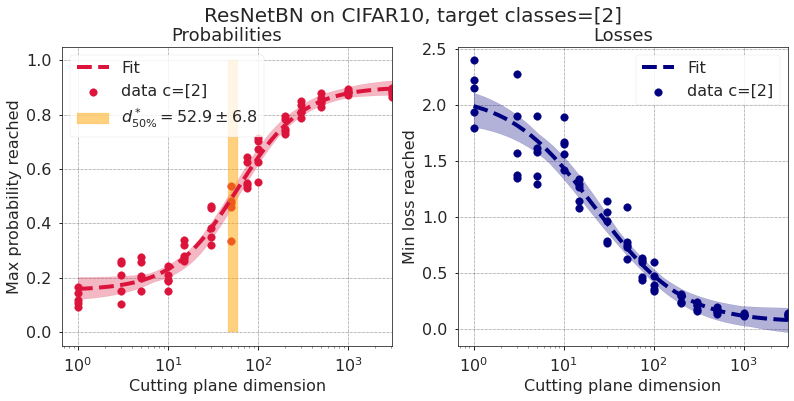

Time remaining approximately 107 seconds.
Starting cs=[3]
onehot_target [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]
d=1 rep=0/5 p=[0.20358106]->0.24353424 loss=1.4124978 stop step=31 dt=0.16936755180358887


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


d=1 rep=1/5 p=[0.2647435]->0.2694912 loss=1.3112196 stop step=14 dt=0.12312769889831543
d=1 rep=2/5 p=[0.20593967]->0.30001122 loss=1.2039354 stop step=62 dt=0.26299619674682617
d=1 rep=3/5 p=[0.23008582]->0.23602757 loss=1.4438066 stop step=11 dt=0.11088132858276367
d=1 rep=4/5 p=[0.38062966]->0.38654444 loss=0.9505085 stop step=8 dt=0.10299277305603027
d=3 rep=0/5 p=[0.17412706]->0.34883434 loss=1.053158 stop step=171 dt=0.5967509746551514
d=3 rep=1/5 p=[0.19779064]->0.20830587 loss=1.5687478 stop step=15 dt=0.12284398078918457
d=3 rep=2/5 p=[0.19184664]->0.26071924 loss=1.3443112 stop step=34 dt=0.18066143989562988
d=3 rep=3/5 p=[0.202953]->0.31977737 loss=1.1401303 stop step=74 dt=0.30617451667785645
d=3 rep=4/5 p=[0.21249728]->0.22866648 loss=1.4754907 stop step=17 dt=0.13277840614318848
d=5 rep=0/5 p=[0.22008525]->0.22574672 loss=1.4883417 stop step=10 dt=0.10687589645385742
d=5 rep=1/5 p=[0.20572232]->0.24621122 loss=1.4015656 stop step=49 dt=0.22307133674621582
d=5 rep=2/5 p=[0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:122: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


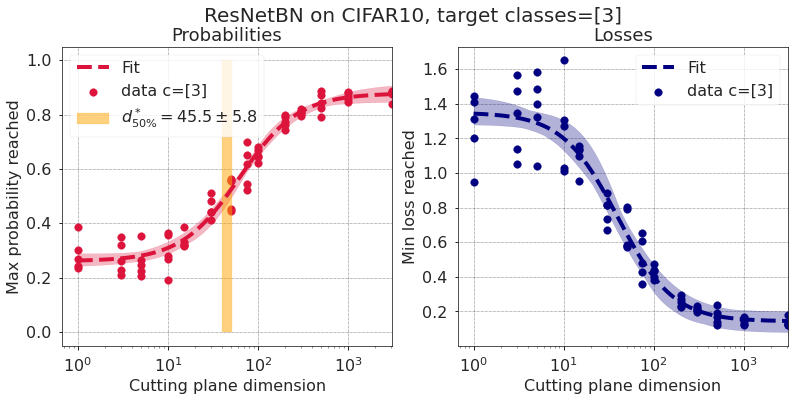

Time remaining approximately 78 seconds.
Starting cs=[4]
onehot_target [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]
d=1 rep=0/5 p=[0.06399898]->0.064549774 loss=2.7403185 stop step=7 dt=0.10479736328125


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


d=1 rep=1/5 p=[0.08785661]->0.087861955 loss=2.4319885 stop step=6 dt=0.09200358390808105
d=1 rep=2/5 p=[0.06237919]->0.07659614 loss=2.5692086 stop step=22 dt=0.13197875022888184
d=1 rep=3/5 p=[0.09653701]->0.09779659 loss=2.3248656 stop step=13 dt=0.11857342720031738
d=1 rep=4/5 p=[0.09398944]->0.11566956 loss=2.1570177 stop step=47 dt=0.2144784927368164
d=3 rep=0/5 p=[0.1227916]->0.14223514 loss=1.9502738 stop step=21 dt=0.12720441818237305
d=3 rep=1/5 p=[0.10851832]->0.114114575 loss=2.1705523 stop step=25 dt=0.13748526573181152
d=3 rep=2/5 p=[0.0864859]->0.10704358 loss=2.2345192 stop step=58 dt=0.2383120059967041
d=3 rep=3/5 p=[0.074444]->0.08169565 loss=2.5047543 stop step=23 dt=0.13752126693725586
d=3 rep=4/5 p=[0.09625626]->0.10238021 loss=2.2790618 stop step=20 dt=0.13532662391662598
d=5 rep=0/5 p=[0.06230431]->0.14039084 loss=1.963325 stop step=67 dt=0.27814435958862305
d=5 rep=1/5 p=[0.07373859]->0.16786313 loss=1.7846063 stop step=57 dt=0.2553062438964844
d=5 rep=2/5 p=[0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:122: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


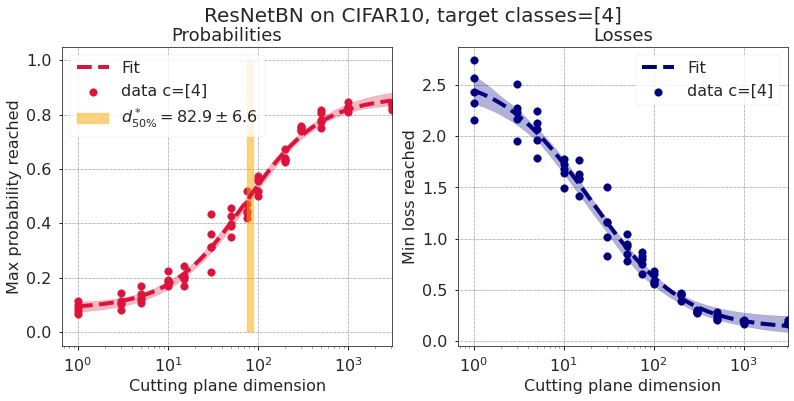

Time remaining approximately 58 seconds.
Starting cs=[5]
onehot_target [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
d=1 rep=0/5 p=[0.10228472]->0.10228472 loss=2.279995 stop step=7 dt=0.10069608688354492


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


d=1 rep=1/5 p=[0.14401667]->0.15152366 loss=1.8870134 stop step=16 dt=0.11217212677001953
d=1 rep=2/5 p=[0.15838937]->0.17290989 loss=1.7549846 stop step=17 dt=0.13239550590515137
d=1 rep=3/5 p=[0.10884993]->0.11085663 loss=2.1995177 stop step=14 dt=0.10556507110595703
d=1 rep=4/5 p=[0.09296888]->0.09296895 loss=2.3754897 stop step=6 dt=0.08158206939697266
d=3 rep=0/5 p=[0.10455003]->0.11724915 loss=2.143454 stop step=33 dt=0.1725468635559082
d=3 rep=1/5 p=[0.14419721]->0.16546713 loss=1.7989829 stop step=27 dt=0.14791250228881836
d=3 rep=2/5 p=[0.1745994]->0.19141628 loss=1.6533048 stop step=17 dt=0.11754846572875977
d=3 rep=3/5 p=[0.10393784]->0.14142998 loss=1.9559506 stop step=22 dt=0.1300060749053955
d=3 rep=4/5 p=[0.15799256]->0.1700295 loss=1.7717834 stop step=20 dt=0.1250922679901123
d=5 rep=0/5 p=[0.08720455]->0.14457345 loss=1.9339676 stop step=36 dt=0.18280625343322754
d=5 rep=1/5 p=[0.12868695]->0.16060463 loss=1.8288097 stop step=41 dt=0.18802642822265625
d=5 rep=2/5 p=[0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:122: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


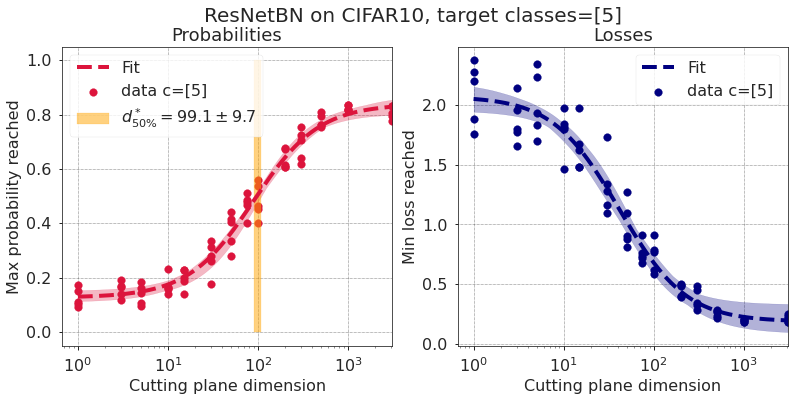

Time remaining approximately 41 seconds.
Starting cs=[6]
onehot_target [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
d=1 rep=0/5 p=[0.04044702]->0.04044702 loss=3.2077622 stop step=12 dt=0.1082613468170166


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


d=1 rep=1/5 p=[0.04377048]->0.04500965 loss=3.1008785 stop step=28 dt=0.16437721252441406
d=1 rep=2/5 p=[0.03912866]->0.044181675 loss=3.1194453 stop step=24 dt=0.13352751731872559
d=1 rep=3/5 p=[0.04817583]->0.051696807 loss=2.9623594 stop step=28 dt=0.1631488800048828
d=1 rep=4/5 p=[0.03954913]->0.047259927 loss=3.0520926 stop step=27 dt=0.14890456199645996
d=3 rep=0/5 p=[0.04320586]->0.06052144 loss=2.8047576 stop step=29 dt=0.15117859840393066
d=3 rep=1/5 p=[0.03962873]->0.04005768 loss=3.217435 stop step=10 dt=0.10111045837402344
d=3 rep=2/5 p=[0.040326]->0.050388046 loss=2.9880013 stop step=31 dt=0.1597602367401123
d=3 rep=3/5 p=[0.02281516]->0.02413073 loss=3.7242692 stop step=31 dt=0.15540814399719238
d=3 rep=4/5 p=[0.04969551]->0.052044205 loss=2.9556618 stop step=20 dt=0.12482380867004395
d=5 rep=0/5 p=[0.03488496]->0.05271792 loss=2.9427998 stop step=49 dt=0.22185897827148438
d=5 rep=1/5 p=[0.0220042]->0.03181012 loss=3.4479709 stop step=35 dt=0.16681647300720215
d=5 rep=2/5

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:122: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


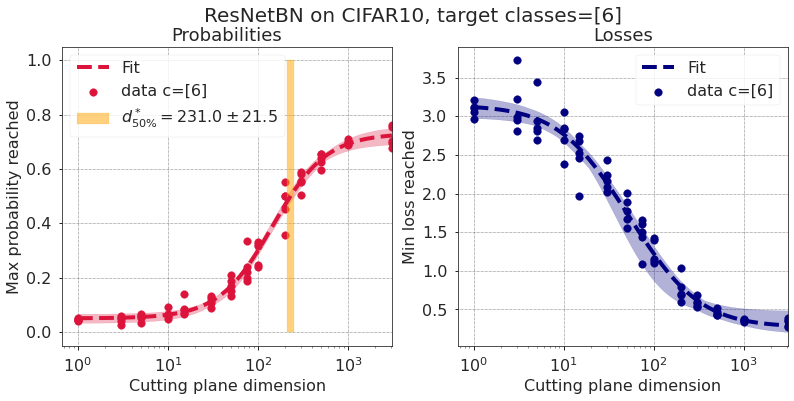

Time remaining approximately 30 seconds.
Starting cs=[7]
onehot_target [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]
d=1 rep=0/5 p=[0.06929922]->0.07085133 loss=2.6471715 stop step=19 dt=0.1294715404510498


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


d=1 rep=1/5 p=[0.03344205]->0.033473603 loss=3.396998 stop step=6 dt=0.0908365249633789
d=1 rep=2/5 p=[0.04754113]->0.05388133 loss=2.9209714 stop step=27 dt=0.1456298828125
d=1 rep=3/5 p=[0.04049656]->0.04517423 loss=3.0972285 stop step=29 dt=0.14916610717773438
d=1 rep=4/5 p=[0.05491876]->0.06820172 loss=2.6852856 stop step=26 dt=0.14541959762573242
d=3 rep=0/5 p=[0.06172147]->0.06946372 loss=2.6669507 stop step=45 dt=0.20271611213684082
d=3 rep=1/5 p=[0.04330993]->0.045964733 loss=3.079881 stop step=17 dt=0.11429858207702637
d=3 rep=2/5 p=[0.04441703]->0.05308989 loss=2.9357688 stop step=38 dt=0.1961064338684082
d=3 rep=3/5 p=[0.04631099]->0.06980299 loss=2.6620784 stop step=44 dt=0.19578027725219727
d=3 rep=4/5 p=[0.06338305]->0.07537081 loss=2.5853353 stop step=21 dt=0.12364053726196289
d=5 rep=0/5 p=[0.02705229]->0.057047866 loss=2.8638647 stop step=134 dt=0.470628023147583
d=5 rep=1/5 p=[0.05835085]->0.097046845 loss=2.3325615 stop step=68 dt=0.26535892486572266
d=5 rep=2/5 p=[0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:122: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


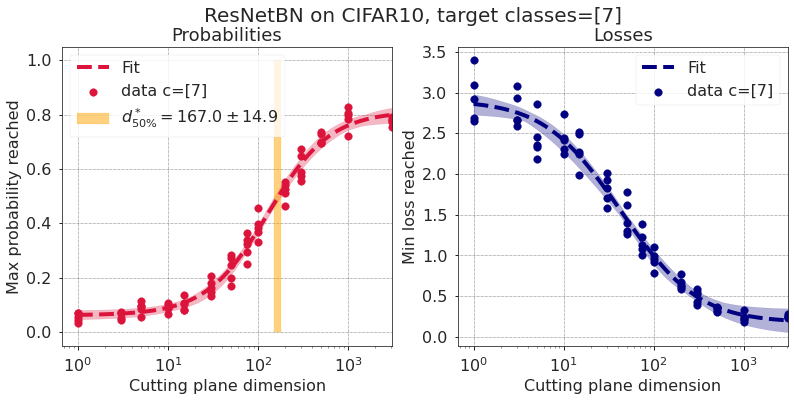

Time remaining approximately 18 seconds.
Starting cs=[8]
onehot_target [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
d=1 rep=0/5 p=[0.03671485]->0.036727767 loss=3.304222 stop step=6 dt=0.08120083808898926


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


d=1 rep=1/5 p=[0.01760148]->0.020227738 loss=3.9007006 stop step=25 dt=0.13907289505004883
d=1 rep=2/5 p=[0.05372587]->0.053942475 loss=2.919837 stop step=6 dt=0.07931995391845703
d=1 rep=3/5 p=[0.01520235]->0.015501502 loss=4.1668186 stop step=27 dt=0.15740227699279785
d=1 rep=4/5 p=[0.02762384]->0.03130205 loss=3.4640718 stop step=30 dt=0.15505599975585938
d=3 rep=0/5 p=[0.01499383]->0.026913203 loss=3.615138 stop step=63 dt=0.24629831314086914
d=3 rep=1/5 p=[0.01967184]->0.025799856 loss=3.6573863 stop step=18 dt=0.11440348625183105
d=3 rep=2/5 p=[0.0378953]->0.040110137 loss=3.2161262 stop step=29 dt=0.1514573097229004
d=3 rep=3/5 p=[0.01780116]->0.022559538 loss=3.7915974 stop step=31 dt=0.15087342262268066
d=3 rep=4/5 p=[0.01599321]->0.023261404 loss=3.7609599 stop step=55 dt=0.2310643196105957
d=5 rep=0/5 p=[0.01395972]->0.026738781 loss=3.6216402 stop step=74 dt=0.30721282958984375
d=5 rep=1/5 p=[0.01614076]->0.03951168 loss=3.231159 stop step=93 dt=0.3452181816101074
d=5 rep=2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:122: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


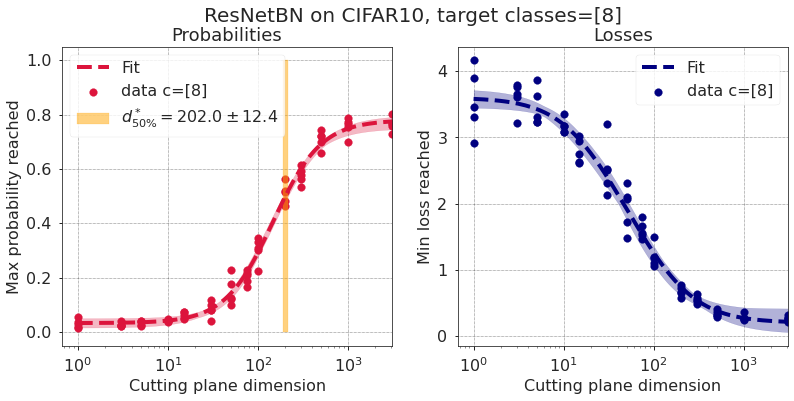

Time remaining approximately 8 seconds.
Starting cs=[9]
onehot_target [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
d=1 rep=0/5 p=[0.08324064]->0.083240636 loss=2.4860196 stop step=6 dt=0.09578752517700195


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


d=1 rep=1/5 p=[0.1000071]->0.106690824 loss=2.2378201 stop step=25 dt=0.1391608715057373
d=1 rep=2/5 p=[0.13080747]->0.13110076 loss=2.031789 stop step=6 dt=0.07578134536743164
d=1 rep=3/5 p=[0.07303793]->0.10543969 loss=2.2496161 stop step=56 dt=0.2395188808441162
d=1 rep=4/5 p=[0.08802277]->0.09429345 loss=2.3613436 stop step=22 dt=0.13567709922790527
d=3 rep=0/5 p=[0.07055792]->0.08502233 loss=2.4648414 stop step=20 dt=0.12864112854003906
d=3 rep=1/5 p=[0.20179062]->0.23994188 loss=1.4273585 stop step=39 dt=0.18013572692871094
d=3 rep=2/5 p=[0.11507422]->0.16471326 loss=1.8035492 stop step=50 dt=0.2130143642425537
d=3 rep=3/5 p=[0.12789483]->0.14532562 loss=1.9287784 stop step=33 dt=0.16542506217956543
d=3 rep=4/5 p=[0.03983413]->0.044650596 loss=3.1088877 stop step=26 dt=0.13832855224609375
d=5 rep=0/5 p=[0.08811674]->0.1359535 loss=1.9954424 stop step=29 dt=0.14948678016662598
d=5 rep=1/5 p=[0.06909334]->0.09085733 loss=2.398465 stop step=30 dt=0.1565108299255371
d=5 rep=2/5 p=[0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:122: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


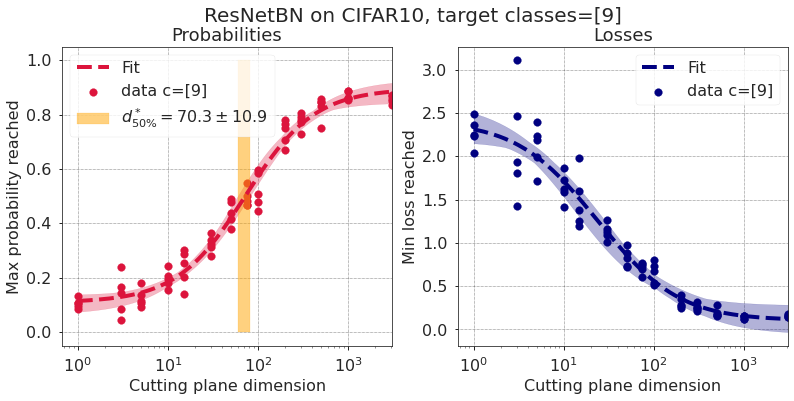

Time remaining approximately 0 seconds.


In [25]:
#the fast fn compilation
opt_fn = jax.jit(fast_optimize_on_plane(LR, plane_steps, classes))

ts = []

storing_all_experiments= []
for class_targets in class_targets_to_explore:
  t1 = time.time()

  print("Starting cs="+str(class_targets))

  #class targets
  # class_targets = [1]
  onehot_target = onp.zeros((classes))
  onehot_target[class_targets] = 1.0/float(len(class_targets))
  onehot_target = onehot_target.reshape([1,-1])
  print("onehot_target",onehot_target)

  onehot_target = jnp.array(onehot_target)

  storing_results = []

  for d in ds_to_explore:
    for rep in range(reps):

      t1 = time.time()

      M_now = make_bases(d,D_input,plane_nonzero_per_vector,True)

      #making it constant dimension to prevent recompilation of the FN 
      #which infers dimensions dynamically
      M_remaining_zeros = onp.zeros((D_input-d,D_input))
      M_now = onp.concatenate([M_now,M_remaining_zeros],axis=0)

      #offset of the plane
      X0 = get_train_image(exclude_classes=class_targets)

      i_final, losses_list, probs_list, thetas_list = opt_fn(M_now, X0, class_targets, params_to_use, ensemble_set_of_params)
      losses_list.block_until_ready()
      probs_list.block_until_ready()
      thetas_list.block_until_ready()

      t2 = time.time()
      
      print("d="+str(d)+
            " rep="+str(rep)+"/"+str(reps)+
            " p="+str(probs_list[0,class_targets])+"->"+str(onp.max(probs_list[:i_final,class_targets]))+
            " loss="+str(onp.min(losses_list[:i_final]))+
            " stop step="+str(len(losses_list[:i_final]))+
            " dt="+str(t2-t1)
            )

      #storing the results
      storing_results.append(
        (d,rep,onp.max(probs_list[:i_final,class_targets]),onp.min(losses_list[:i_final]),probs_list[:i_final],losses_list[:i_final],thetas_list[:i_final])
      )

  #plotting on the fly
  make_a_plot(storing_results,class_targets)

  storing_all_experiments.append(storing_results)

  #countdown
  t2 = time.time()
  ts.append(t2-t1)
  t_rem = onp.mean(ts)*len(class_targets_to_explore) - onp.sum(ts)
  print("Time remaining approximately "+str(int(t_rem))+" seconds.")


# Summary plot for all classes

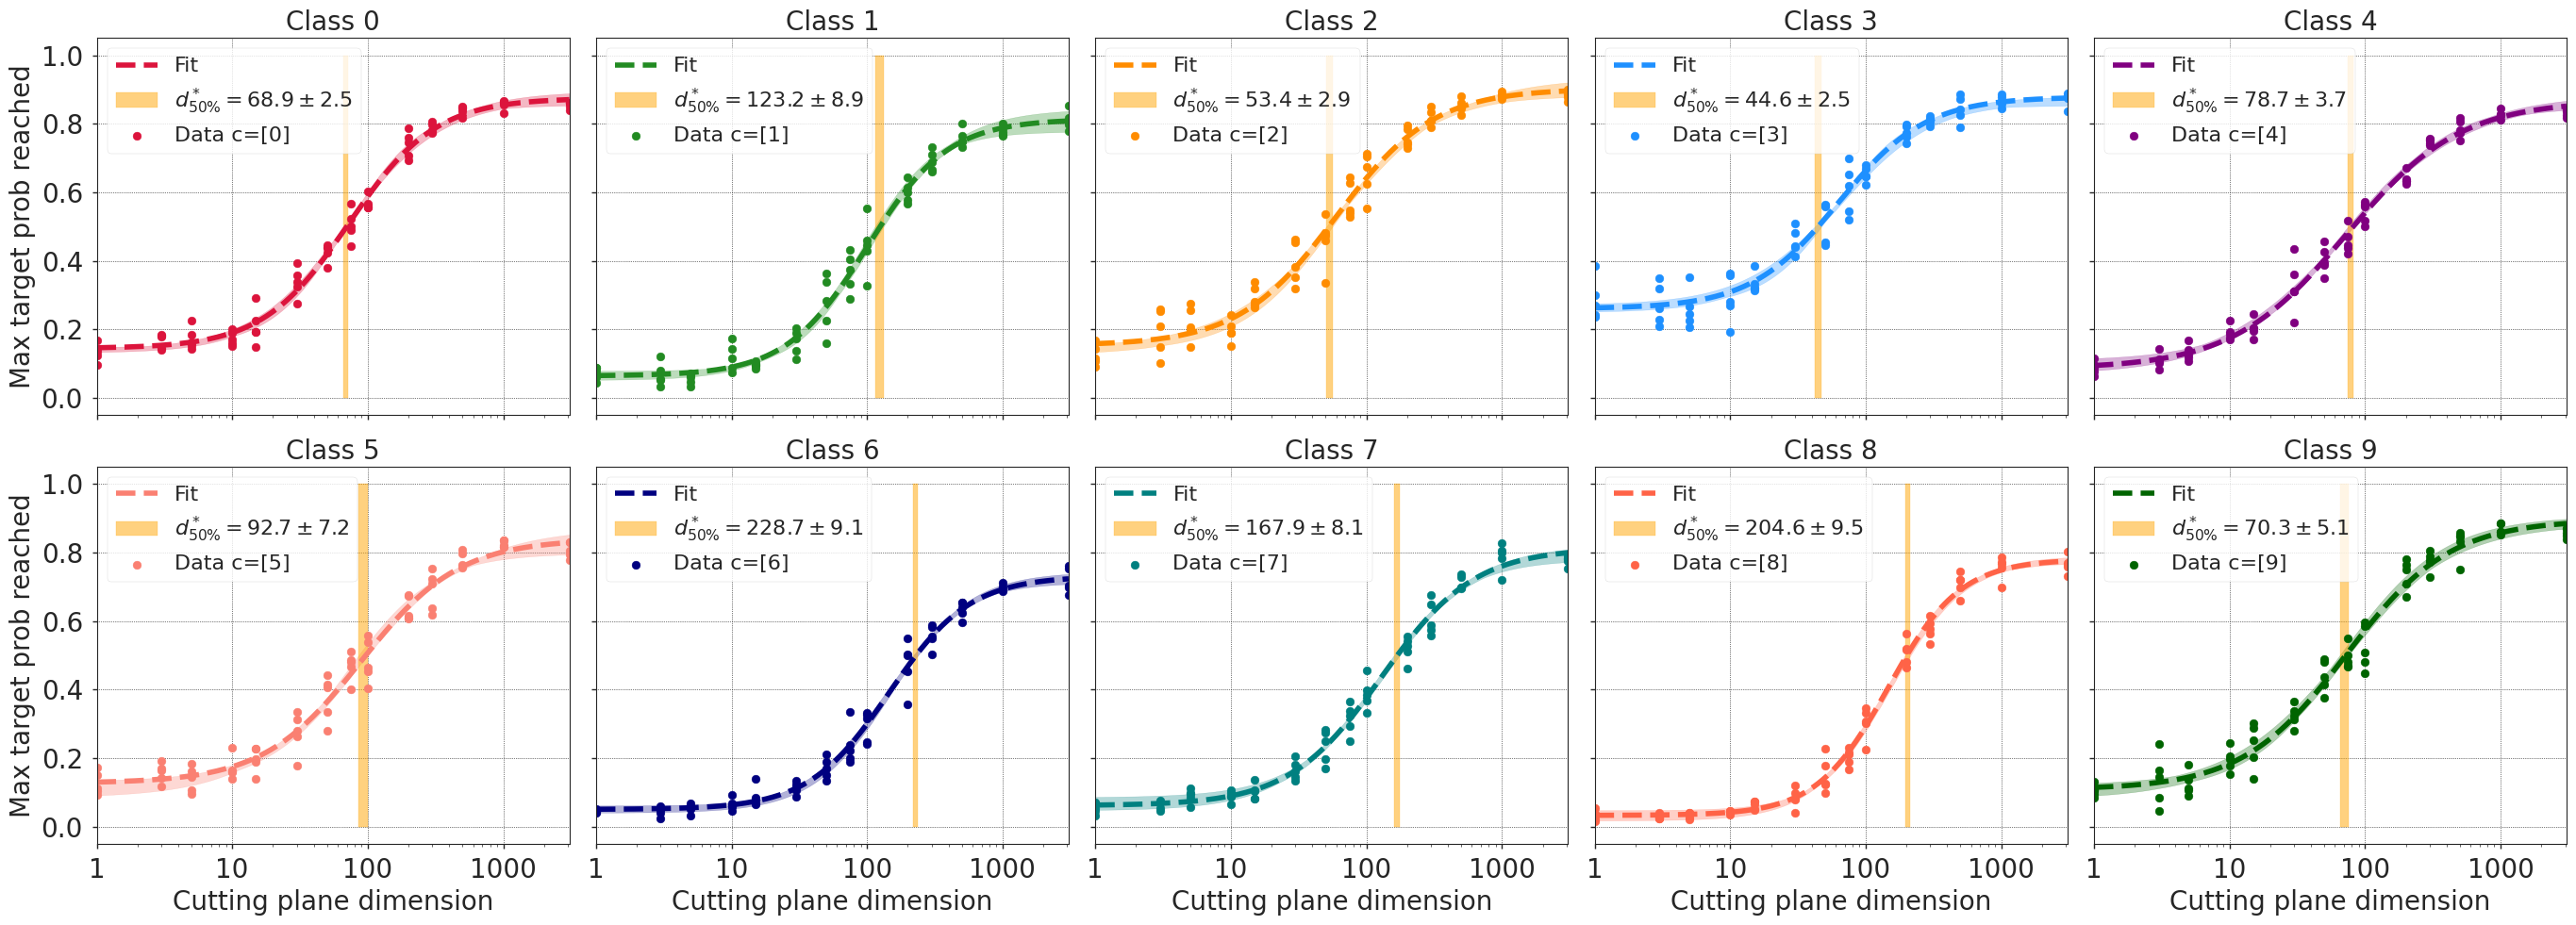

In [26]:
per_row = 5
rows = int(onp.ceil(float(len(class_targets_to_explore)) / float(per_row)))

from scipy.optimize import curve_fit

def func(x, a, b, c, d):
    return a + b/(1.0+onp.exp(-(onp.log(x)-onp.log(c))/d))

plt.figure(figsize = (5.5*per_row,5*rows),dpi = 100)

for i in range(len(class_targets_to_explore)):

  plt.subplot(rows,per_row,i+1)


  storing_results = storing_all_experiments[i]
  class_targets = class_targets_to_explore[i]

  ds_collected = [qs[0] for qs in storing_results]
  ps_collected = [onp.max(onp.mean(qs[4][:,class_targets],axis=-1)) for qs in storing_results]
  
  ds_unique = list(sorted(list(set(ds_collected))))
  vals_collected = [[] for _ in ds_unique]
  for j,d_now in enumerate(ds_unique):
    vals_collected[j] = list(onp.array(ps_collected)[onp.array(ds_collected) == d_now])

  means = onp.mean(onp.array(vals_collected),axis=1)
  errors = onp.std(onp.array(vals_collected),axis=1)

  #fitting
  try:
    # popt, pcov = curve_fit(func, ds_unique, means, sigma=errors)
    p0 = [0.1,1.0,50,2.0]
    popt, pcov = curve_fit(func, ds_collected, ps_collected, p0 = p0)
    fit_done = True

    d_mid = popt[2]
    d_mid_error = onp.sqrt(pcov[2,2]) 
  except:
    fit_done = False

  plt.semilogx()

  colors = ["crimson","forestgreen","darkorange","dodgerblue","purple","salmon","navy","teal","tomato","darkgreen"]
  color = colors[i % len(colors)]

  if fit_done == True:
    #adding the fit
    xs_fit = onp.linspace(onp.min(ds_unique),onp.max(ds_unique),10000)
    ys_fit = func(xs_fit,*popt)

    label = "$d^*="+str(d_mid)[:4]+"\pm"+str(d_mid_error)[:4]+"$"
    label = "Fit"

    plt.plot(xs_fit,ys_fit,linestyle = "--",color = color,linewidth = 4,label = label)

    M_fns = 10
    all_fit_params = onp.random.multivariate_normal(mean = popt,cov = pcov, size=(M_fns))
    ys_fit_all = []
    for params in all_fit_params:
      ys_fit = func(xs_fit,*params)
      ys_fit_all.append(ys_fit)
    ys_fit_all = onp.array(ys_fit_all)

    plt.fill_between(xs_fit,onp.min(ys_fit_all,axis=0),onp.max(ys_fit_all,axis=0),color = color,alpha = 0.3)

    #getting the distribution of crossing 50%
    min_ids = onp.argmin(onp.abs(onp.array(ys_fit_all) - 0.5),axis=-1)
    d_50_min = onp.min(xs_fit[min_ids])
    d_50_max = onp.max(xs_fit[min_ids])

    mean_str = "{:.1f}".format((d_50_min+d_50_max)/2.0)
    error_str = "{:.1f}".format((d_50_max-d_50_min)/2.0)
    label = "$d^*_{50\%}="+mean_str+"\pm"+error_str+"$"
    plt.fill_between([d_50_min,d_50_max],[0.0,0.0],[1.0,1.0],color = "orange",alpha = 0.5,label = label)

  plt.xlim([1,3072])

  #data
  plt.scatter(ds_collected,ps_collected,marker = "o",color = color,s = 40,label = "Data c="+str(class_targets),alpha = 1.0)


  if i >= per_row*(rows-1): #bottom row x labels
    plt.xlabel("Cutting plane dimension",fontsize = 20)
 
  if i % per_row == 0: #left column ylabels only
    plt.ylabel("Max target prob reached",fontsize = 20)

  ticks = [1,10,100,1000]
  if i >= per_row*(rows-1): #bottom row x labels 
    plt.xticks(ticks=ticks,labels=ticks,fontsize = 20)
  else:
    plt.xticks(ticks=ticks,labels=[],fontsize = 20)

  ticks = [0.0,0.2,0.4,0.6,0.8,1.0]
  if i % per_row == 0: #left column ylabels only
    plt.yticks(ticks=ticks,labels=ticks,fontsize = 20)
  else:
    plt.yticks(ticks=ticks,labels=[],fontsize = 20)

  plt.title("Class "+str(class_targets[0]),fontsize = 20)

  plt.legend(fontsize = 16)

plt.tight_layout()


plt.show()
